In [1]:
import os
import pandas as pd

def aggregate_pred_dataframe(files):
    print(files)
    dfs = [pd.read_csv(f) for f in files]
    final_df = dfs[0].rename(columns={'pred': 'pred_0'})
    for i in range(1, len(dfs)):
        final_df[f'pred_{i}'] = dfs[i]['pred']
    return final_df.reset_index()

def get_preds_with_prefixes(prefixes, seed_start=0, seed_end=20):
    if prefixes is str:
        prefixes = [prefixes]
    csv_files = [file for file in os.listdir('preds') if file.endswith('.csv')]
    csv_files.sort()
    len(csv_files)
    preds = []
    for seed in range(seed_start, seed_end):
        for prefix in prefixes:            
            filtered = [file for file in csv_files if file.startswith(f'{prefix}_{seed:02d}_')] # get all file with same seed
            if filtered:
                preds.append((filtered[-1], filtered[-2])) # get the one with highest mcc value (valid and test)
    return preds

def aggregate_preds(preds):
    df_valid = aggregate_pred_dataframe([f'preds/{i[0]}' for i in preds])
    df_test = aggregate_pred_dataframe([f'preds/{i[1]}' for i in preds])
    
    return df_valid, df_test

%matplotlib inline
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, matthews_corrcoef
import matplotlib.pyplot as plt
import numpy as np

def round_dict(d, n):
    return {k: round(v, n) if isinstance(v, float) else v
                for k, v in d.items()}

def generate_mean_ensemble_metrics(df, threshold=0):
    sum_preds = df[list(filter(lambda a: a.startswith('pred_'), df.columns.tolist()))].mean(axis=1)
    final_prediction = (sum_preds > threshold).astype(int)

    # Sensitivity (Recall)
    sensitivity = recall_score(df['target'], final_prediction)

    # Specificity
    tn, fp, fn, tp = confusion_matrix(df['target'], final_prediction).ravel()
    specificity = tn / (tn + fp)

    # Accuracy
    accuracy = accuracy_score(df['target'], final_prediction)

    # Precision
    precision = precision_score(df['target'], final_prediction)
    mcc = matthews_corrcoef(df['target'], final_prediction)
    return {
        "sensitivity": sensitivity,
        "specificity": specificity,
        "accuracy": accuracy,
        "precision": precision,
        "mcc": mcc,
    }
    
def draw_mean_ensemble_thrshold_chart(df_valid, df_test, start=-3, end=1, step=0.1,
                                      plot=True):
    # Create a list of thresholds to test
    thresholds = np.arange(start, end, step)  # Adjust the step size as necessary
    valid_mccs = []
    test_metrics = []

    # Loop through thresholds and compute MCC
    for threshold in thresholds:
        metrics = generate_mean_ensemble_metrics(df_valid, threshold)
        valid_mccs.append(metrics['mcc'])
        
        metrics_test = generate_mean_ensemble_metrics(df_test, threshold)
        test_metrics.append(metrics_test)

    # Identify threshold with the best MCC
    best_threshold_arg = np.argmax(valid_mccs)
    best_threshold = thresholds[best_threshold_arg]

    label = f'Best Threshold: {best_threshold:.1f}, Valid MCC: {valid_mccs[best_threshold_arg]:.3f}, Test MCC: {test_metrics[best_threshold_arg]["mcc"]:.3f}'
    # Plot
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, valid_mccs, label='Valid MCC', color='blue')
        plt.plot(thresholds, [i['mcc'] for i in test_metrics], label='Test MCC', color='green')
        plt.axvline(x=best_threshold, color='red', linestyle='--', label=label)
        plt.xlabel('Threshold')
        plt.ylabel('MCC Value')
        plt.title('MCC vs. Threshold')
        plt.legend()
        plt.grid(True)
        plt.show()
    return {
        'best_threshold': best_threshold, 
        'valid_mcc': valid_mccs[best_threshold_arg],
        **test_metrics[best_threshold_arg]
    }


def random_small_ensembles(preds, n, trial, start=-3, end=1, step=0.1):
    from random import sample
    df = pd.DataFrame()
    for i in range(trial):
        sample_preds = sample(preds, n)
        df_valid = aggregate_pred_dataframe([f'preds/{i[0]}' for i in sample_preds])
        df_test = aggregate_pred_dataframe([f'preds/{i[1]}' for i in sample_preds])


        new_row = [draw_mean_ensemble_thrshold_chart(df_valid, df_test, start=start, end=end, step=step, plot=False)]
        new_df = pd.DataFrame(new_row)
        df = pd.concat([df, new_df], ignore_index=True)

    return df


def summarize_prefix(prefixes, n, plot=False, start=-3, end=1, step=0.1, apply_sig=False, seed_start=0, seed_end=20):
    preds = get_preds_with_prefixes(prefixes, seed_start=seed_start, seed_end=seed_end)
    df_valid, df_test = aggregate_preds(preds)
    print(f'Ensemble of all {len(preds)} models:')
    
    if apply_sig:
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))
        # Apply the sigmoid function to all pred columns
        pred_columns = df_valid.filter(like='pred_').columns
        df_valid[pred_columns] = df_valid[pred_columns].apply(sigmoid)
        df_test[pred_columns] = df_test[pred_columns].apply(sigmoid)
    print(round_dict(draw_mean_ensemble_thrshold_chart(df_valid, df_test, start=start, end=end, step=step, plot=plot), 4))

    print(f'Ensemble of {n} random models:')
    df = random_small_ensembles(preds, n, 10, start=start, end=end, step=step)
    return df.aggregate(['mean', 'std', 'max']).T.round(3)


['preds/adaboost_00_valid.csv', 'preds/adaboost_01_valid.csv', 'preds/adaboost_02_valid.csv', 'preds/adaboost_03_valid.csv', 'preds/adaboost_04_valid.csv', 'preds/adaboost_05_valid.csv', 'preds/adaboost_06_valid.csv', 'preds/adaboost_07_valid.csv', 'preds/adaboost_08_valid.csv', 'preds/adaboost_09_valid.csv']
['preds/adaboost_00_test.csv', 'preds/adaboost_01_test.csv', 'preds/adaboost_02_test.csv', 'preds/adaboost_03_test.csv', 'preds/adaboost_04_test.csv', 'preds/adaboost_05_test.csv', 'preds/adaboost_06_test.csv', 'preds/adaboost_07_test.csv', 'preds/adaboost_08_test.csv', 'preds/adaboost_09_test.csv']
Ensemble of all 10 models:


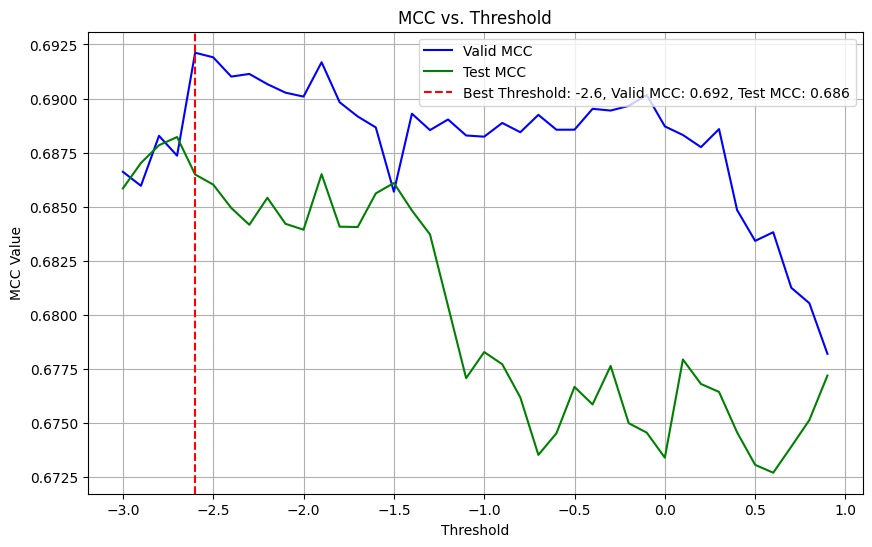

{'best_threshold': -2.6, 'valid_mcc': 0.6921, 'sensitivity': 0.697, 'specificity': 0.9843, 'accuracy': 0.9694, 'precision': 0.7083, 'mcc': 0.6865}
Ensemble of 10 random models:
['preds/adaboost_04_valid.csv', 'preds/adaboost_09_valid.csv', 'preds/adaboost_01_valid.csv', 'preds/adaboost_06_valid.csv', 'preds/adaboost_00_valid.csv', 'preds/adaboost_05_valid.csv', 'preds/adaboost_07_valid.csv', 'preds/adaboost_03_valid.csv', 'preds/adaboost_08_valid.csv', 'preds/adaboost_02_valid.csv']
['preds/adaboost_04_test.csv', 'preds/adaboost_09_test.csv', 'preds/adaboost_01_test.csv', 'preds/adaboost_06_test.csv', 'preds/adaboost_00_test.csv', 'preds/adaboost_05_test.csv', 'preds/adaboost_07_test.csv', 'preds/adaboost_03_test.csv', 'preds/adaboost_08_test.csv', 'preds/adaboost_02_test.csv']
['preds/adaboost_07_valid.csv', 'preds/adaboost_06_valid.csv', 'preds/adaboost_03_valid.csv', 'preds/adaboost_05_valid.csv', 'preds/adaboost_09_valid.csv', 'preds/adaboost_02_valid.csv', 'preds/adaboost_04_valid

,mean,std,max
best_threshold,-2.600,0.0,-2.600
valid_mcc,0.692,0.0,0.692
sensitivity,0.697,0.0,0.697
specificity,0.984,0.0,0.984
accuracy,0.969,0.0,0.969
precision,0.708,0.0,0.708
mcc,0.686,0.0,0.686


In [5]:
summarize_prefix(['adaboost'], 10, plot=True, start=-3, end=1, step=0.1, seed_start=0, seed_end=10)